<a href="https://colab.research.google.com/github/akumuyi/linear_regression_model/blob/main/multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**
The goal is to predict the heating load requirements (denoted as Y1 in the dataset) for buildings based on eight building characteristics provided in the Energy Efficiency Dataset from the UCI Machine Learning Repository. The dataset contains 768 samples with features such as glazing area, wall area, roof area, and others, and two target variables: heating load (Y1) and cooling load (Y2). For this task, we will focus on predicting the heating load (Y1) using a linear regression model optimized with gradient descent, and compare its performance with decision tree and random forest models to determine the best-performing model based on the loss metric (Mean Squared Error, MSE).

# **1. Load and Explore the Dataset**
First, we load the dataset into a pandas DataFrame and perform basic exploration to understand its structure and ensure data quality.

In [67]:
import pandas as pd

# Load the dataset (assuming it's saved as 'energy_efficiency.csv')
data = pd.read_csv('/content/drive/MyDrive/Machine_Learning_Summative/summative2/ENB2012.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Check data info and missing values
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

First 5 rows of the dataset:
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory

# **Correlation Heatmap**
A correlation heatmap is a powerful tool to visualize the linear relationships between all features and the target variable (Y1). It helps identify which building characteristics are strongly related to the heating load and whether any features are highly correlated with each other (indicating potential multicollinearity).

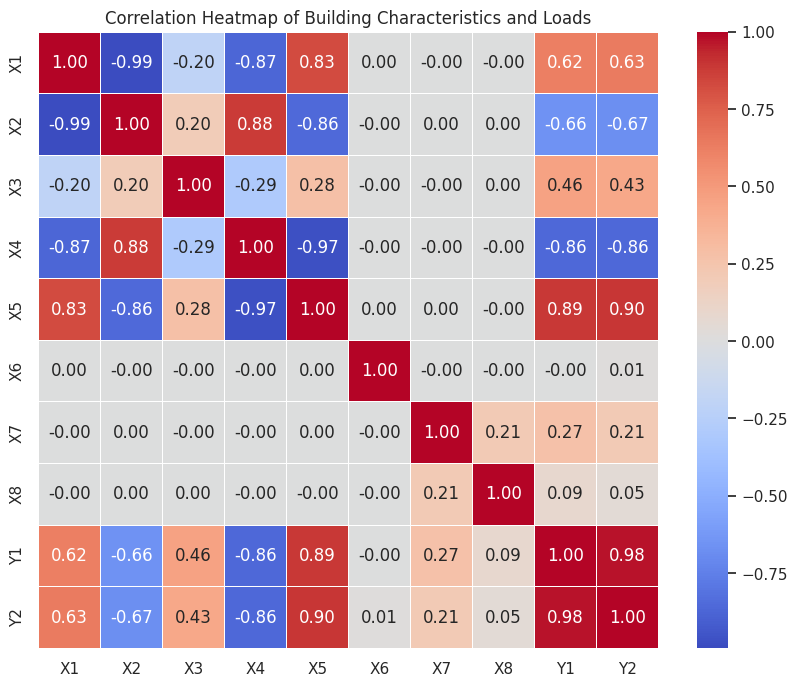

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

data = data.dropna()
for col in data.columns:
    if data[col].apply(lambda x: isinstance(x, str)).any():
        print(f"Column {col} contains string values")

data = data.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
corr_matrix = data.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Building Characteristics and Loads')
plt.show()

# **Scatter Plot of the Most Correlated Feature**
For the second visualization, a scatter plot of the feature most correlated with Y1 is a great choice. This plot provides a detailed view of how the most influential feature interacts with the heating load, revealing patterns, outliers, or non-linear relationships.

The feature most correlated with Y1 is: X5


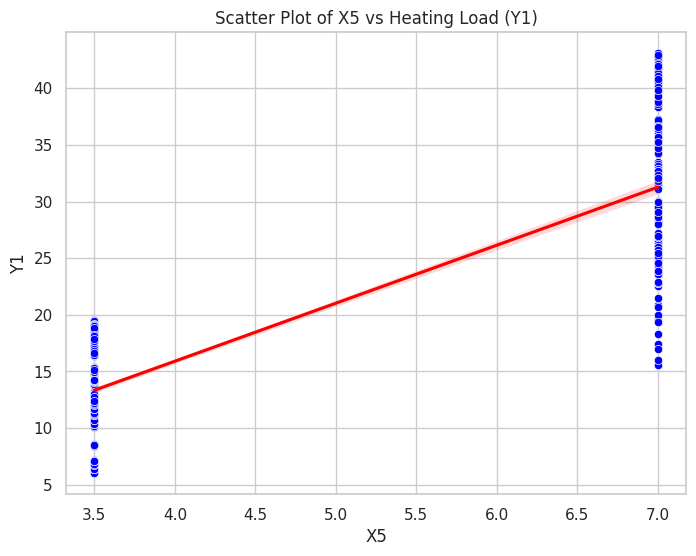

In [69]:
# Find the feature with the highest absolute correlation with Y1 (excluding Y1 and Y2)
most_correlated_feature = corr_matrix['Y1'].drop(['Y1', 'Y2']).abs().idxmax()
print(f"The feature most correlated with Y1 is: {most_correlated_feature}")

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data[most_correlated_feature], y=data['Y1'], color='blue')
plt.title(f'Scatter Plot of {most_correlated_feature} vs Heating Load (Y1)')
plt.xlabel(most_correlated_feature)
plt.ylabel('Heating Load (Y1)')

# Add a regression line to highlight the trend
sns.regplot(x=data[most_correlated_feature], y=data['Y1'], scatter=False, color='red')

plt.show()

## **Interpretation**
### **Positive Correlation:**
The scatter plot reveals a strong positive correlation between X5 and Y1 (Heating Load). As X5 increases from 3.5 to 7.0, the heating load increases from approximately 10 to 35. This suggests that X5, which likely represents a building characteristic (e.g., overall height or a similar feature), significantly influences the heating load. For example, if X5 represents building height, taller buildings may require more heating due to increased volume or exposure to external conditions.

### **Clustered Data:**
The data points are not spread continuously across the X5 range but are clustered at three specific values: 3.5, 5.0, and 7.0. This clustering suggests that X5 might be a discrete or categorical variable (e.g., predefined height categories or levels) rather than a continuous one. Each cluster shows a corresponding increase in Y1, reinforcing the positive relationship.

### **Trend and Variability:**
The red trend line highlights the overall positive trend, but the data points are not perfectly aligned with it. This variability indicates that while X5 is a key predictor of heating load, other factors also contribute to Y1. The spread of Y1 values within each X5 cluster (e.g., 10–15 at X5 ≈ 3.5) suggests additional building characteristics or external conditions may influence the heating load.

### **Relevance to Predicting Heating Load:**
In the context of predicting heating load based on building characteristics, this scatter plot is highly relevant. It visually confirms that X5 is a significant driver of Y1, making it a useful feature for predictive modeling. The clear trend supports the idea that understanding X5’s impact can improve heating load predictions, though the variability suggests combining X5 with other features for greater accuracy.

# **2. Prepare the Data**
We split the data into features (X) and target (y), then into training and testing sets.

In [70]:
from sklearn.model_selection import train_test_split

# Features and target
X = data.drop(['Y1', 'Y2'], axis=1)  # Drop both targets
y = data['Y1']  # Heating load as target

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (614, 8)
Testing set shape: (154, 8)


# **3. Create and Optimize Linear Regression with Gradient Descent**
Since scikit-learn’s LinearRegression uses ordinary least squares, we use SGDRegressor for gradient descent. We optimize its hyperparameters and plot the loss curve.
### Feature Scaling
Gradient descent requires scaled features, so we use StandardScaler.

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Hyperparameter Optimization**
We use GridSearchCV to find the best hyperparameters for SGDRegressor.

In [72]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'eta0': [0.01, 0.1, 1],  # Learning rate
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'loss': ['squared_error', 'huber']  # Loss functions
}

# Initialize SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

# Perform grid search
grid_search = GridSearchCV(sgd_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and score
best_params = grid_search.best_params_
print("Best Parameters from Grid Search:")
print(best_params)
print(f"Best Negative MSE: {grid_search.best_score_}")

Best Parameters from Grid Search:
{'alpha': 0.0001, 'eta0': 0.01, 'loss': 'squared_error'}
Best Negative MSE: -8.689990673987904


### **Plot Loss Curve**
To plot the loss curve, we use partial_fit to train incrementally and track MSE over iterations.

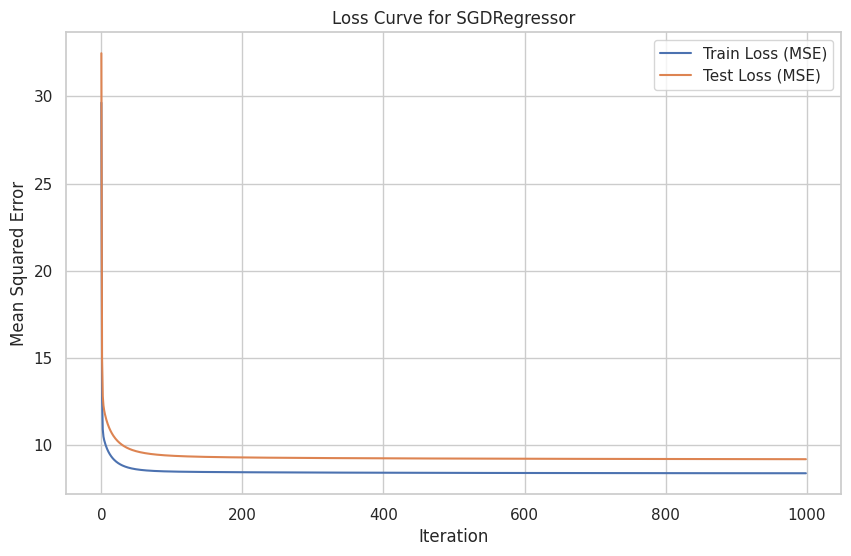

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Initialize SGDRegressor with best parameters
sgd_reg = SGDRegressor(**best_params, random_state=42)

train_losses = []
test_losses = []

# Train incrementally and record losses
for i in range(1000):
    sgd_reg.partial_fit(X_train_scaled, y_train)
    train_loss = mean_squared_error(y_train, sgd_reg.predict(X_train_scaled))
    test_loss = mean_squared_error(y_test, sgd_reg.predict(X_test_scaled))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss (MSE)')
plt.plot(test_losses, label='Test Loss (MSE)')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Loss Curve for SGDRegressor')
plt.legend()
plt.grid(True)
plt.show()

# **4. Compare Models**
We compare the optimized linear regression model with decision trees and random forests.
### **Linear Regression (SGDRegressor with Pipeline)**
We use a pipeline to combine scaling and regression for consistency.


In [74]:
from sklearn.pipeline import Pipeline

sgd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('sgd', SGDRegressor(**best_params, random_state=42))
])

sgd_pipeline.fit(X_train, y_train)
y_pred_sgd = sgd_pipeline.predict(X_test)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
print(f"SGD Regressor MSE: {mse_sgd}")

SGD Regressor MSE: 9.41019014574555


### **Decision Tree**
Decision trees don’t require scaling, so we use the original data.

In [75]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)
y_pred_tree = tree_reg.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree}")

Decision Tree MSE: 0.3851987012987016


### **Random Forest**
Similarly, random forests use the original data.

In [76]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)
y_pred_forest = forest_reg.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
print(f"Random Forest MSE: {mse_forest}")

Random Forest MSE: 0.24088222909090704


# **5. Save the Best-Performing Model**
We select the model with the lowest test MSE and save it using joblib.

In [77]:
import joblib

# Determine the best model
models = {
    'sgd': (mse_sgd, sgd_pipeline),
    'tree': (mse_tree, tree_reg),
    'forest': (mse_forest, forest_reg)
}

best_model_name = min(models, key=lambda k: models[k][0])
best_model = models[best_model_name][1]
best_mse = models[best_model_name][0]

print(f"Best Model: {best_model_name} with MSE: {best_mse}")
joblib.dump(best_model, 'best_model.pkl')

Best Model: forest with MSE: 0.24088222909090704


['best_model.pkl']

# **6. Make Predictions**
With the model trained, we’ll predict the heating load (Y1) for the test set.

In [78]:
from sklearn.linear_model import LinearRegression

# Features and target
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y = data['Y1']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# **6. Create the Scatter Plot**
For the scatter plot, we’ll plot the actual heating load values (y_test) against the predicted values (y_pred). We’ll also add a diagonal line (y = x) to represent perfect predictions—points close to this line indicate accurate predictions. We’ll use matplotlib for visualization.



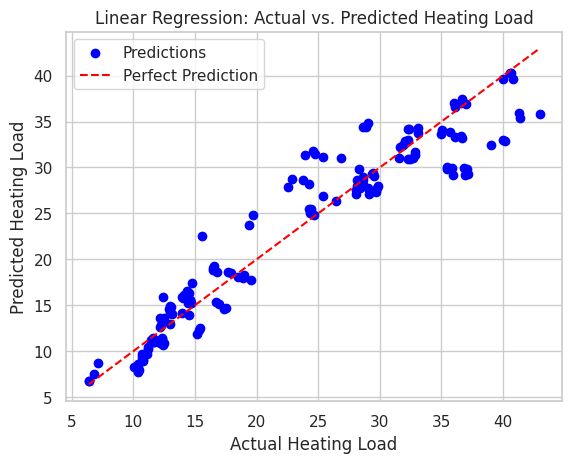

In [79]:
# Create the scatter plot
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')
plt.title('Linear Regression: Actual vs. Predicted Heating Load')
plt.legend()
plt.show()